In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import tensorflow
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
#MAPE 
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_csv('datameetupr (2).csv', index_col=[0], parse_dates=['date'])

In [4]:
df.head()

,Daily Active Users
date,
2013-01-01,1567
2013-01-02,3267
2013-01-03,4058
2013-01-04,4003
2013-01-05,3902


In [5]:
df.describe()

,Daily Active Users
count,894.000000
mean,8699.209172
std,3472.651537
min,257.000000
25%,5563.500000
50%,8957.000000
75%,11867.250000
max,15427.000000


In [6]:
split_date = '29-Jan-2015'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

In [7]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

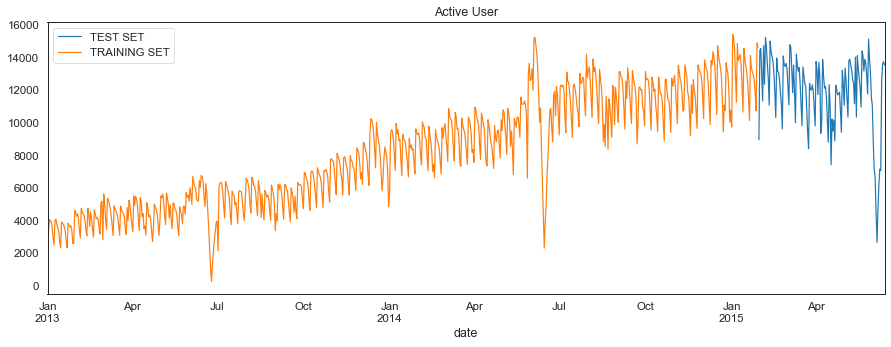

In [8]:
_ = data_test \
    .rename(columns={'Daily Active Users': 'TEST SET'}) \
    .join(data_train.rename(columns={'Daily Active Users': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Active User', style='-')

In [9]:
#LSTM Model
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 758 samples
Epoch 1/100
758/758 - 19s - loss: 0.1906
Epoch 2/100
758/758 - 0s - loss: 0.0574
Epoch 3/100
758/758 - 0s - loss: 0.0546
Epoch 4/100
758/758 - 0s - loss: 0.0559
Epoch 5/100
758/758 - 0s - loss: 0.0466
Epoch 6/100
758/758 - 1s - loss: 0.0456
Epoch 7/100
758/758 - 0s - loss: 0.0451
Epoch 8/100
758/758 - 0s - loss: 0.0440
Epoch 9/100
758/758 - 0s - loss: 0.0435
Epoch 10/100
758/758 - 1s - loss: 0.0430
Epoch 11/100
758/758 - 0s - loss: 0.0424
Epoch 12/100
758/758 - 0s - loss: 0.0417
Epoch 13/100
758/758 - 0s - loss: 0.0411
Epoch 14/100
758/758 - 0s - loss: 0.0405
Epoch 15/100
758/758 - 0s - loss: 0.0399
Epoch 16/100
758/758 - 0s - loss: 0.0393
Epoch 17/100
758/758 - 0s - loss: 0.0387
Epoch 18/100
758/758 - 0s - loss: 0.0380
Epoch 19/100
758/758 - 0s - loss: 0.0373
Epoch 20/100
758/758 - 0s - loss: 0.0367
Epoch 21/100
758/758 - 0s - loss: 0.0361
Epoch 22/100
758/758 - 0s - loss

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_dau = model.predict(inputs)
predicted_dau = sc.inverse_transform(predicted_dau)

In [13]:
data_test['Prediction'] = predicted_dau
data_all = pd.concat([data_test, data_train], sort=False)

In [14]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Prediction': 'lstm'})
final_data = final_data[['date','Daily Active Users','lstm']]

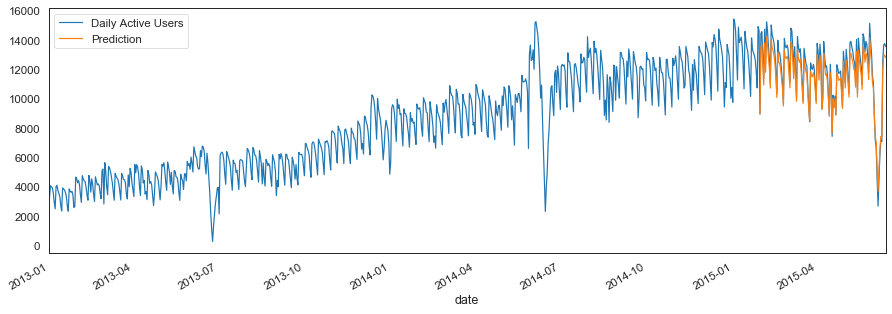

In [15]:
_ = data_all[['Daily Active Users','Prediction']].plot(figsize=(15, 5))

In [17]:
mean_absolute_percentage_error(y_true=data_test['Daily Active Users'],
                   y_pred=data_test['Prediction'])

4.823018838096089